# Convergence testing and parameter recovery

Here we're testing with the SDE model `rev-08a` both convergence $\hat{R}$ values and recovery of simulated parameters.

In [67]:
%pylab inline
import lib.io.stan
import lib.plots.stan
import importlib

Populating the interactive namespace from numpy and matplotlib


## Compile Stan model

In [48]:
%%bash
. /soft/stan/activate
h=`pwd`; cd $CMDSTAN; make CC=g++ $h/vep-fe-rev-08a;

activating stan v2.17.0

--- Translating Stan model to C++ code ---
bin/stanc  /home/duke/src/vep/vep-fe-rev-08a.stan --o=/home/duke/src/vep/vep-fe-rev-08a.hpp
Model name=vep_fe_rev_08a_model
Input file=/home/duke/src/vep/vep-fe-rev-08a.stan
Output file=/home/duke/src/vep/vep-fe-rev-08a.hpp

--- Linking C++ model ---
g++ -Wall -I . -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.64.0 -isystem stan/lib/stan_math/lib/cvodes_2.9.0/include -std=c++1y -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -I src -I stan/src -isystem stan/lib/stan_math/ -DEIGEN_NO_DEBUG -DFUSION_MAX_VECTOR_SIZE=12 -DNO_FPRINTF_OUTPUT -pipe -Wl,-rpath,/soft/gcc630/bin -Wl,-rpath,/soft/gcc492/bin  -lpthread  -O3 -o /home/duke/src/vep/vep-fe-rev-08a src/cmdstan/main.cpp -include /home/duke/src/vep/vep-fe-rev-08a.hpp stan/lib/stan_math/lib/cvodes_2.9.0/lib/libsundials_nvecserial.a stan/lib/stan_math/lib/cvodes_2.9.0/lib/lib

make: Warning: File `/home/duke/src/vep/vep-fe-rev-08a.stan' has modification time 529 s in the future
make: warning:  Clock skew detected.  Your build may be incomplete.


## Simulate

In this simulation, I'm simply disabling the sampling statement which predicts the data, and allowing the sampler to converge to priors, which runs very quickly.

In [ ]:
%%bash
. /soft/stan/activate
cp Rfiles/trec-p0-s2-n6.R tmp.R
echo "predict_data <- 0" >> tmp.R
./vep-fe-rev-08a sample save_warmup=1 num_warmup=200 num_samples=10 \
    data file=tmp.R output refresh=10 file=tmp.csv &> /dev/null

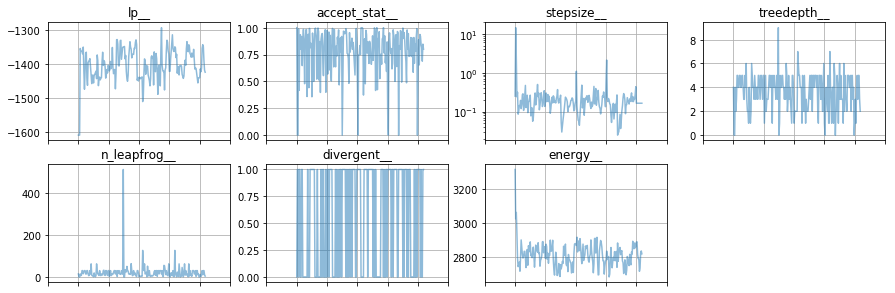

In [2]:
csv = [lib.io.stan.parse_csv('tmp.csv')]
figure(figsize=(15, 10))
lib.plots.stan.trace_nuts(csv)

Example trajectories of $x(t)$ for nodes for a 10 simulations

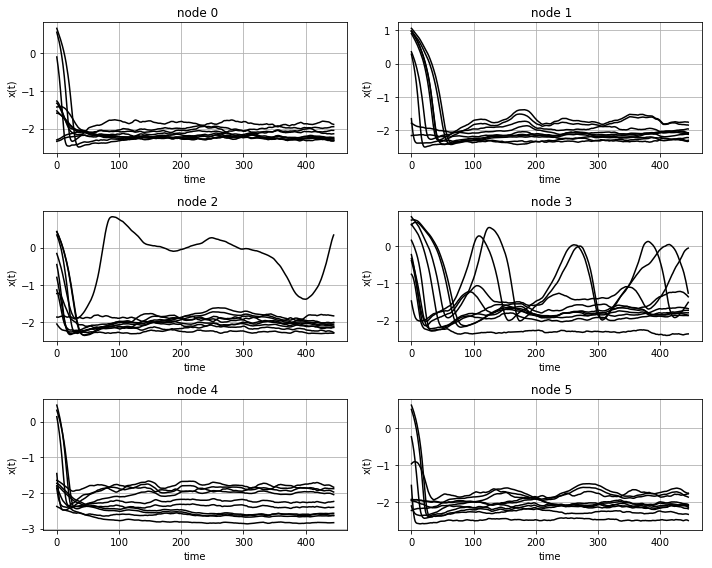

In [46]:
figure(figsize=(10, 8))
for i, xi in enumerate(transpose(csv[0]['x'][-10:], (1, 0, 2))):
    subplot(3, 2, i + 1)
    plot(xi.T[20:], 'k')
    grid(1), ylabel(f'x(t)'), xlabel('time'), title(f' node {i}')
tight_layout()

Let's keep one with the transient for testing,

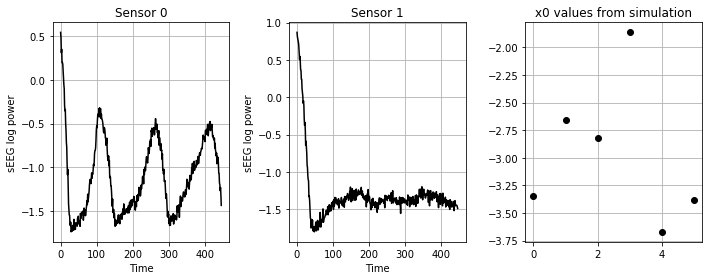

In [50]:
figure(figsize=(10, 4))
for i in range(2):
    subplot(1, 3, i + 1)
    plot(csv[0]['gq_seeg_log_power'][-6, i, 20:].T, 'k')
    grid(1), xlabel('Time'), ylabel('sEEG log power'), title(f'Sensor {i}')
subplot(133), plot(csv[0]['x0'][-6], 'ko'), grid(1), title('x0 values from simulation');
tight_layout()

## Convert simulated data to input

In [187]:
tmp = lib.io.stan.rload('tmp.R')
tmp['seeg_log_power'] = csv[0]['gq_seeg_log_power'][-6].T
tmp['predict_data'] = tmp['nt']
lib.io.stan.rdump('tmp2.R', tmp)

## Fit simulated data

Now we'll fit the simulated data, but here we need several chains, more samples and larger tree depth.  Runs a bit longer than the simulation.

In [8]:
%%bash
. /soft/stan/activate
for i in `seq 16`
do
    ./vep-fe-rev-08a id=$i sample save_warmup=1 num_warmup=200 num_samples=200 \
        algorithm=hmc engine=nuts max_depth=14 \
        data file=tmp2.R output refresh=1 file=tmp2.$i.csv &> tmp2.$i.out &
done

activating stan v2.17.0


In [56]:
!for i in `seq 16`; do echo chain $i `grep Iteration tmp2.$i.out | tail -n 1`; done

chain 1 Iteration: 400 / 400 [100%] (Sampling)
chain 2 Iteration: 400 / 400 [100%] (Sampling)
chain 3 Iteration: 400 / 400 [100%] (Sampling)
chain 4 Iteration: 400 / 400 [100%] (Sampling)
chain 5 Iteration: 400 / 400 [100%] (Sampling)
chain 6 Iteration: 400 / 400 [100%] (Sampling)
chain 7 Iteration: 400 / 400 [100%] (Sampling)
chain 8 Iteration: 400 / 400 [100%] (Sampling)
chain 9 Iteration: 400 / 400 [100%] (Sampling)
chain 10 Iteration: 400 / 400 [100%] (Sampling)
chain 11 Iteration: 400 / 400 [100%] (Sampling)
chain 12 Iteration: 400 / 400 [100%] (Sampling)
chain 13 Iteration: 400 / 400 [100%] (Sampling)
chain 14 Iteration: 400 / 400 [100%] (Sampling)
chain 15 Iteration: 400 / 400 [100%] (Sampling)
chain 16 Iteration: 400 / 400 [100%] (Sampling)


OK, done let's load that

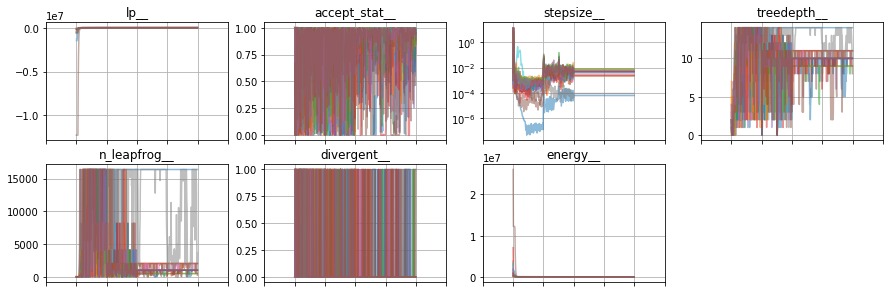

In [17]:
csv2 = lib.io.stan.parse_csv('tmp2.*.csv', merge=False)
figure(figsize=(15, 10))
lib.plots.stan.trace_nuts(csv2)

## Convergence

Let's get the summary especially check $\hat{R}$ values

In [70]:
%%bash
. /soft/stan/activate
stansummary --csv_file=tmp2-summary.csv tmp2.*.csv &> tmp2-summary.txt

activating stan v2.17.0


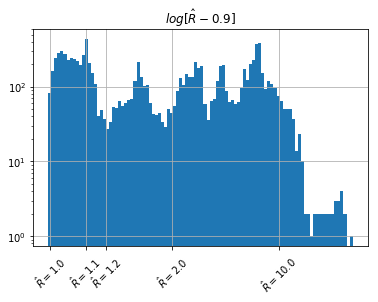

In [114]:
summ_fields, summ_dat = lib.io.stan.parse_summary_csv('tmp2-summary.csv')

rhats = np.hstack([_[...,-1].reshape((-1, )) for k, _ in summ_dat.items() if '__' not in k])
hist(log(rhats -0.9), 100, log=True), title('$log [\hat{R} - 0.9]$');
rhat_vals = r_[1, 1.1, 1.2, 2, 10]
xticks(log(rhat_vals-0.9), ['$\hat{{R}} = %0.1f$'%(v,) for v in rhat_vals], rotation=45)
grid(1)

Ideally, we want to see $\hat{R}$, the majority of $\hat{R}$ values are > 2, suggesting lack of convergnece. Let's look at effect on parameter recovery: 

## Parameter recovery
It's useful to have chains both merged and unmerged, here `csv2_` is the set of samples merged across all chains

In [43]:
csv2_ = lib.io.stan.merge_csv_data(*csv2, skip=10)

Plot the `x0` posterior

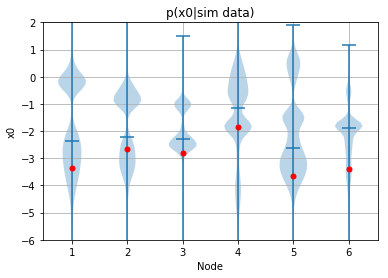

In [115]:
violinplot(csv2_['x0'][200:], showmedians=True)
plot(np.r_[1:7], csv[0]['x0'][-6], 'ro', markersize=5)
ylim([-6, 2]), grid(1), ylabel('x0'), xlabel('Node'), title('p(x0|sim data)');

Where the red dots are the true values.

We can also see multimodality in the trajectories:

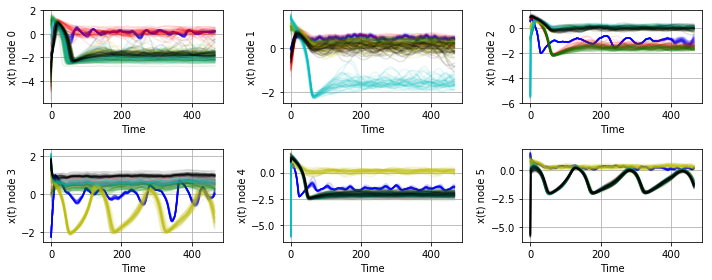

In [116]:
figure(figsize=(10,4))
for i in range(6):
    subplot(2, 3, i + 1)
    for j, csv2_ in enumerate(csv2[:6]):
        _ = csv2_['x'][200::5, i].T
        plot(_, 'brgyckm'[j], alpha=0.1)
    grid(1), ylabel(f'x(t) node {i}'), xlabel('Time')
tight_layout()

Here the trajectories are colored by chain.